## **Imports**

In [17]:
# Imports
import pandas as pd  # Data manipulation and analysis
import numpy as np   # Support for large, multi-dimensional arrays and matrices
import os            # Interfacing with the operating system
%pip install lxml    # Install lxml library for XML and HTML processing
from lxml import etree  # XML and HTML manipulation
%pip install requests # Install requests library for HTTP operations
import requests      # Library to make HTTP requests
import xml.etree.ElementTree as ET  # XML parsing and manipulation
from collections import defaultdict  # Dictionary that provides a default value for missing keys
import seaborn as sns
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **Load and inspect data**

In [2]:
# Load from csv
person = pd.read_csv('data/Person Person.csv', delimiter=',')

# Inspect columns
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19972 entries, 0 to 19971
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   BusinessEntityID       19972 non-null  int64 
 1   PersonType             19972 non-null  object
 2   NameStyle              19972 non-null  bool  
 3   Title                  1009 non-null   object
 4   FirstName              19972 non-null  object
 5   MiddleName             11473 non-null  object
 6   LastName               19972 non-null  object
 7   Suffix                 53 non-null     object
 8   EmailPromotion         19972 non-null  int64 
 9   AdditionalContactInfo  10 non-null     object
 10  Demographics           19972 non-null  object
 11  rowguid                19972 non-null  object
 12  ModifiedDate           19972 non-null  object
dtypes: bool(1), int64(2), object(10)
memory usage: 1.8+ MB


In [3]:
# Inspect data
person.head()

,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1722,IN,False,NaN,Mandar,NaN,Samant,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000
1,2389,IN,False,NaN,Laura,NaN,Liu,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000
2,2391,IN,False,NaN,Laura,NaN,Wu,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000
3,2397,IN,False,NaN,Isabella,NaN,Cox,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000
4,2401,IN,False,NaN,Laura,NaN,Gao,NaN,0,NaN,"<IndividualSurvey xmlns=""http://schemas.micros...",D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000


> ☝ **Findings** and⚡ **Actions**:

1. There are a number of columns with high proportions of missing values: `Title`, `Suffix`, `AdditionalContactInfo`. Based on the column names, it's unlikely these will be useful for segmentation so I can remove them. 
2. Columns recording name information (`Firstname`, `MiddleName`, `LastName`) won't be needed for this project either, so I can remove these too. 
3. The `PersonType` column contains descriptive labels about each person's relationship to AdventureWorks. For initial analysis, I'll concentrate on "individual customers" (those with an "IN" value) so I'll subset out these individuals. 
4. The `Demographics` column contains XML values with demographic information that will be useful for segmentation. In order to work with the information, I'll need to extract it from XML format into structured columns.  

## **Subset and prepare data**

In [4]:
# Drop columns
person = person.drop(['NameStyle',
                      'Title',
                      'FirstName',
                      'MiddleName',
                      'LastName',
                      'Suffix',
                      'AdditionalContactInfo'], axis = 1)

# Subset individual customers
person_in = person[person['PersonType']=='IN']

# Drop PersonType column, which is no longer needed
person_in = person_in.drop('PersonType', axis = 1)

# Reset row indices to allow for concatenation later
person_in.reset_index(inplace=True, drop=True)

# Inspect data
person_in.head()


,BusinessEntityID,EmailPromotion,Demographics,rowguid,ModifiedDate
0,1722,0,"<IndividualSurvey xmlns=""http://schemas.micros...",6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000
1,2389,0,"<IndividualSurvey xmlns=""http://schemas.micros...",0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000
2,2391,0,"<IndividualSurvey xmlns=""http://schemas.micros...",D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000
3,2397,0,"<IndividualSurvey xmlns=""http://schemas.micros...",09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000
4,2401,0,"<IndividualSurvey xmlns=""http://schemas.micros...",D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000


> ☝ **Findings** and⚡ **Actions**:

1. The `Demographics` column is in XML; a flexible format for storing data in a tree-like structure. 
2. I need to parse the XML values and extract data into new columns. The function below is designed to do that. 

In [5]:
# Function to parse XML and extract all items
def xml_to_columns(xml_string):
    # Namespace for schema
    ns = {'aw': 'http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey'}
    
    # Parse the XML string into a tree structure
    tree = ET.fromstring(xml_string)
    
    # Initialize a dictionary to store items, defaulting missing entries to None
    items = defaultdict(lambda: None)
    
    # Iterate through each element in the XML tree, using the namespace map
    for element in tree.findall('.//aw:*', namespaces=ns):
        # Extract the tag and remove the namespace information for clarity
        tag = element.tag.split('}')[-1]  
        # Store the element's text content under the tag in the items dictionary
        items[tag] = element.text
    
    return pd.Series(items)

In [9]:
# Apply the function 
extracted_xml_columns = person_in['Demographics'].apply(xml_to_columns)

# Concatenate the newly columns back onto the original dataframe
person_in = person_in.join(extracted_xml_columns)

# Drop the original Demographics columns, which is no longer needed
person_in = person_in.drop(['Demographics'], axis = 1)

# Inspect
person_in.head()

,BusinessEntityID,EmailPromotion,rowguid,ModifiedDate,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance
0,1722,0,6F123B92-FF1E-4F18-A054-F1477D965B36,2013-04-08 00:00:00.000,3499.8504,2003-05-10Z,1974-09-18Z,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles
1,2389,0,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,2013-09-04 00:00:00.000,1085.5,2003-10-06Z,1967-10-05Z,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles
2,2391,0,D2535AEE-7780-4CAC-9737-5D23895FD5B5,2012-04-20 00:00:00.000,36.59,2002-05-22Z,1973-10-21Z,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles
3,2397,0,09FB996B-2BD4-454F-A9D2-F0F307D13039,2013-10-06 00:00:00.000,-3.99,2003-11-07Z,1978-08-28Z,S,25001-50000,F,0,0,Partial High School,Clerical,1,2,5-10 Miles
4,2401,0,D319CB69-2139-4F0C-AEA6-541B3D5B0412,2014-05-15 00:00:00.000,12.99,2004-06-15Z,1939-11-03Z,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles


> ☝ **Findings** and⚡ **Actions**:

1. After extraction from XML, values are treated as strings by default. 
2. Therefore data type conversions will be needed to make these fields suitable for further analysis.  


## **Pre-process and transform data**

In [10]:
# Inspect columns
person_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   BusinessEntityID      18484 non-null  int64 
 1   EmailPromotion        18484 non-null  int64 
 2   rowguid               18484 non-null  object
 3   ModifiedDate          18484 non-null  object
 4   TotalPurchaseYTD      18484 non-null  object
 5   DateFirstPurchase     18484 non-null  object
 6   BirthDate             18484 non-null  object
 7   MaritalStatus         18484 non-null  object
 8   YearlyIncome          18484 non-null  object
 9   Gender                18484 non-null  object
 10  TotalChildren         18484 non-null  object
 11  NumberChildrenAtHome  18484 non-null  object
 12  Education             18484 non-null  object
 13  Occupation            18484 non-null  object
 14  HomeOwnerFlag         18484 non-null  object
 15  NumberCarsOwned       18484 non-null

> ☝ **Findings** and⚡ **Actions**:

As expected, all the newly extracted fields are `object` type. After checking the values, these are the data type transformations needed to make them suitable for modelling. 

1. **Floats**
    - `TotalPurchaseYTD`

2. **Dates**
    - `DateFirstPurchase`	
    - `BirthDate`
    - `ModifiedDate`

3. **Categories**
    - `EmailPromotion` # This feature is not from the XML string but it should be represented as a category instead of int
    - `BusinessEntityID`
    - `MaritalStatus`	
    - `YearlyIncome`	
    - `Gender`
    - `Education`	
    - `Occupation`
    - `CommuteDistance`

4. **Integers**
    - `TotalChildren`	
    - `NumberChildrenAtHome`
    - `HomeOwnerFlag`	
    - `NumberCarsOwned`


Additionally, some of these values will not be very useful in their raw form but can be used to derive more meaningful features (eg, customer birthdays are less useful than age for understanding behaviour). After data type conversions, I should perform some feature development. 

### Data type conversions

In [11]:
# Float conversions
person_in['TotalPurchaseYTD'] = person_in['TotalPurchaseYTD'].astype(float)

# Datetime conversions
person_in['DateFirstPurchase'] = pd.to_datetime(person_in['DateFirstPurchase'], format='%Y-%m-%dZ')
person_in['BirthDate'] = pd.to_datetime(person_in['BirthDate'], format='%Y-%m-%dZ')
person_in['ModifiedDate'] = pd.to_datetime(person_in['ModifiedDate'])

# Category conversions
person_in['BusinessEntityID'] = person_in['BusinessEntityID'].astype('category')
person_in['MaritalStatus'] = person_in['MaritalStatus'].astype('category')
person_in['YearlyIncome'] = person_in['YearlyIncome'].astype('category')
person_in['Gender'] = person_in['Gender'].astype('category')
person_in['Education'] = person_in['Education'].astype('category')
person_in['Occupation'] = person_in['Occupation'].astype('category')
person_in['CommuteDistance'] = person_in['CommuteDistance'].astype('category')

# Define promotional email mapping dict
promo_email_mapping_dict = {
    0: 'no_email_promos',
    1: 'aw_email_promos',
    2: 'aw_plus_email_promos'
}
# Apply promo email mapping dict
person_in['EmailPromotion'] = person_in['EmailPromotion'].replace(promo_email_mapping_dict)

# Category conversion
person_in['EmailPromotion'] = person_in['EmailPromotion'].astype('category')

# Integer conversions
person_in['TotalChildren'] = person_in['TotalChildren'].astype(int)
person_in['NumberChildrenAtHome'] = person_in['NumberChildrenAtHome'].astype(int)
person_in['HomeOwnerFlag'] = person_in['HomeOwnerFlag'].astype(int)
person_in['NumberCarsOwned'] = person_in['NumberCarsOwned'].astype(int)

# Inspect
person_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   BusinessEntityID      18484 non-null  category      
 1   EmailPromotion        18484 non-null  category      
 2   rowguid               18484 non-null  object        
 3   ModifiedDate          18484 non-null  datetime64[ns]
 4   TotalPurchaseYTD      18484 non-null  float64       
 5   DateFirstPurchase     18484 non-null  datetime64[ns]
 6   BirthDate             18484 non-null  datetime64[ns]
 7   MaritalStatus         18484 non-null  category      
 8   YearlyIncome          18484 non-null  category      
 9   Gender                18484 non-null  category      
 10  TotalChildren         18484 non-null  int64         
 11  NumberChildrenAtHome  18484 non-null  int64         
 12  Education             18484 non-null  category      
 13  Occupation      

### Feature extraction

In [12]:
def calculate_age(birthdate, reference_date):
    """
    Calculate age in years from birthdate to a given reference date.

    Args:
    birthdate (pd.Series): Pandas Series of birth dates.
    reference_date (pd.Timestamp): The date from which to calculate the age.

    Returns:
    pd.Series: Age in years on the reference date.
    """
    return (reference_date - birthdate).dt.days // 365

def days_since_date(first_purchase_date, reference_date):
    """
    Calculate time in days since the first purchase date to a given reference date.

    Args:
    first_purchase_date (pd.Series): Pandas Series of first purchase dates.
    reference_date (pd.Timestamp): The date from which to calculate the years since first purchase.

    Returns:
    pd.Series: Days from first purchase to the reference date.
    """
    return (reference_date - first_purchase_date).dt.days 


In [13]:
# Set a reference date
reference_date = pd.Timestamp('2024-01-01') 

# Apply the functions to calculate age and time in days since first purchase
person_in['Age'] = calculate_age(person_in['BirthDate'], reference_date)
person_in['DaysSinceFirstPurchase'] = days_since_date(person_in['DateFirstPurchase'], reference_date)

# Calculate years since first purchase as a more intuitive measure
person_in['YearsSinceFirstPurchase'] = person_in['DaysSinceFirstPurchase'] / 365

# Drop columns
person_in = person_in.drop(['BirthDate', 'DateFirstPurchase', 'ModifiedDate', 'DaysSinceFirstPurchase'], axis = 1)

# Inspect
person_in.head()

,BusinessEntityID,EmailPromotion,rowguid,TotalPurchaseYTD,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance,Age,YearsSinceFirstPurchase
0,1722,no_email_promos,6F123B92-FF1E-4F18-A054-F1477D965B36,3499.8504,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles,49,20.660274
1,2389,no_email_promos,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,1085.5000,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles,56,20.252055
2,2391,no_email_promos,D2535AEE-7780-4CAC-9737-5D23895FD5B5,36.5900,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles,50,21.627397
3,2397,no_email_promos,09FB996B-2BD4-454F-A9D2-F0F307D13039,-3.9900,S,25001-50000,F,0,0,Partial High School,Clerical,1,2,5-10 Miles,45,20.164384
4,2401,no_email_promos,D319CB69-2139-4F0C-AEA6-541B3D5B0412,12.9900,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles,84,19.558904


## **Exploratory Data Analysis**

We can perform some exploratory data analysis to better understand the data. 

### Number of unique individuals

In [14]:
n_records = person_in.shape[0]
n_individuals = person_in.BusinessEntityID.nunique()
n_duplicates = person_in.drop(columns=['BusinessEntityID']).duplicated(keep=False).sum()

print(f"""
      Number of records: {n_records}
      Number of unique IDS: {n_individuals}
      Number of duplicates (not including unique ID): {n_duplicates}
      """)


      Number of records: 18484
      Number of unique IDS: 18484
      Number of duplicates (not including unique ID): 0
      


> ☝ **Findings** and⚡ **Actions**:

1. There are approximately 18,400 unique customers included in this dataset. 
2. There are no duplicate records and no action needs to be taken. 

### Individuals receiving promotional emails

/tmp/ipykernel_7049/3540824660.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promo_email_values.index,


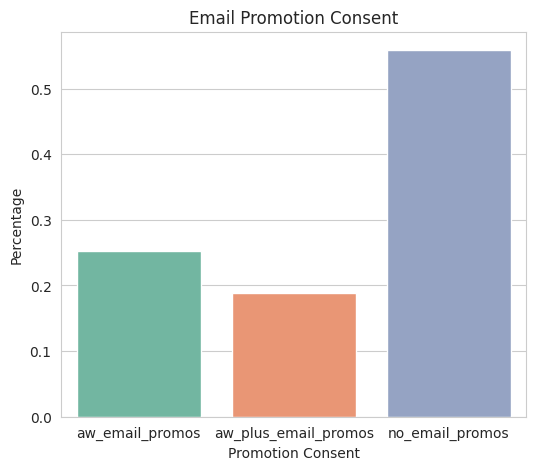

EmailPromotion
no_email_promos         0.558916
aw_email_promos         0.252489
aw_plus_email_promos    0.188596
Name: proportion, dtype: float64

In [27]:
# Extract promotional email preference value counts
promo_email_values = person_in.EmailPromotion.value_counts(normalize=True)

# Setting the seaborn style to "whitegrid" for better grid visibility
sns.set_style("whitegrid")

# Plot the values using seaborn barplot
plt.figure(figsize=(6, 5))
sns.barplot(x=promo_email_values.index,
            y=promo_email_values.values, palette='Set2')
plt.title('Email Promotion Consent')
plt.xlabel('Promotion Consent')
plt.ylabel('Percentage')
plt.show()

# Print values too 
promo_email_values

> ☝ **Findings** and⚡ **Actions**:

1. Slightly over half customers have opted out of promotional emails, around a quarter have opted in to promotional emails from Adventure Works, and around 19% have opted in to emails from both Adventure Works and selected partners. 
2. This could be valuable information for segmentation, assuming that those who are willing to receive promotional emails are more engaged with Adventure Works and may have different spending habits. 

/tmp/ipykernel_7049/3451148500.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in, palette='Set2')


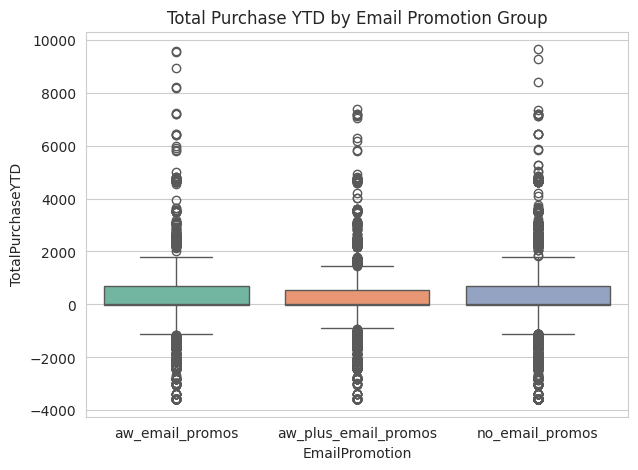

In [31]:
# Plot distributions of TotalPurchaseYTD per group
sns.set_style("whitegrid")  
plt.figure(figsize=(7, 5))
sns.boxplot(x='EmailPromotion', y='TotalPurchaseYTD', data=person_in, palette='Set2')
plt.title('Total Purchase YTD by Email Promotion Group')
plt.show()

> ☝ **Findings** and⚡ **Actions**:

1. Bizarrely, there are large numbers of negative spend values for each group.  The distribution of purchases seems to vary widely across all three groups. 
2. This could indicate that the `TotalPurchaseYTD` column records profit made from customers purchases, and that these customers recieved a number of refunds. Or, more likely, these are errors which need to be corrected or excluded. 
3. 

### Yearly purchase amount

In [ ]:
person_in.TotalPurchaseYTD.describe()

count    18484.000000
mean       302.986341
std       1354.347946
min      -3578.270000
25%        -29.990000
50%         19.980000
75%        692.360000
max       9650.760000
Name: TotalPurchaseYTD, dtype: float64

> ☝ **Findings** and⚡ **Actions**:

1. Interestingly, more than a quarter of customers have negative yearly purchase amounts. 
2. This could indicate that the `TotalPurchaseYTD` column records profit made from customers purchases and not the total value, or that they have recieved a number of refunds.
3. Understanding and predicting customers whose purchases result in negative profit will likely be an important thing to identify, so let's create a new feature we can use for this.  

In [21]:
# Create a binary column indicating if TotalPurchaseYTD non-negative
person_in['PositivePurchaseYTD'] = (person_in['TotalPurchaseYTD'] >= 0).astype(int)

# Inspect
person_in.head()

,BusinessEntityID,EmailPromotion,rowguid,TotalPurchaseYTD,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,CommuteDistance,Age,YearsSinceFirstPurchase,NonNegativePurchase,NonNegativePurchaseYTD,PositivePurchaseYTD
0,1722,no_email_promos,6F123B92-FF1E-4F18-A054-F1477D965B36,3499.8504,S,0-25000,F,0,0,Partial High School,Manual,0,2,0-1 Miles,49,20.660274,1,1,1
1,2389,no_email_promos,0BB7741C-53C5-4502-AABC-AA3E798EC6E7,1085.5000,S,25001-50000,F,5,5,High School,Skilled Manual,1,3,10+ Miles,56,20.252055,1,1,1
2,2391,no_email_promos,D2535AEE-7780-4CAC-9737-5D23895FD5B5,36.5900,S,greater than 100000,F,0,5,Partial College,Management,1,3,10+ Miles,50,21.627397,1,1,1
3,2397,no_email_promos,09FB996B-2BD4-454F-A9D2-F0F307D13039,-3.9900,S,25001-50000,F,0,0,Partial High School,Clerical,1,2,5-10 Miles,45,20.164384,0,0,0
4,2401,no_email_promos,D319CB69-2139-4F0C-AEA6-541B3D5B0412,12.9900,M,25001-50000,F,2,0,Bachelors,Management,1,2,5-10 Miles,84,19.558904,1,1,1


### Marital status

In [22]:
person_in.MaritalStatus.value_counts(normalize=True)

MaritalStatus
M    0.541604
S    0.458396
Name: proportion, dtype: float64

> ☝ **Findings** and⚡ **Actions**:

Slightly over half our customers are married. 